# Домашнее задание

In [2]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-26 18:32:43--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-26 18:32:43--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-11-26 18:32:43 ERROR 404: Not Found.

--2021-11-26 18:32:43--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-11-26 18:32:43--  http

In [1]:
!pip install torchmetrics
!pip install ipdb

In [2]:
!pip install pymystem3

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
import nltk
from nltk import word_tokenize
from string import punctuation
import re
import gensim
import matplotlib as plt
from pymystem3 import Mystem
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
torch.cuda.manual_seed_all(42)
torch.manual_seed(42)

## Подготовка данных

In [7]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0
all_tweets_data = pos_tweets.append(neg_tweets)
tweets_data = shuffle(all_tweets_data[['text','tone']])

In [8]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

tweets_data['prep_text'] = [preprocess_text(text) for text in tweets_data['text']]
train_data, val_data = train_test_split(tweets_data, test_size=0.2) 

In [9]:
word_vocab = Counter()
for text in tweets_data['prep_text']:
    word_vocab.update(word_tokenize(text))
print('всего уникальных символов:', len(word_vocab))

filtered_word_vocab = set()

for word in word_vocab:
    if word_vocab[word] > 2:
        filtered_word_vocab.add(word)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_word_vocab))

word2id = {'PAD':0}

for word in filtered_word_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

всего уникальных символов: 180371
уникальных символов, втретившихся больше 5 раз: 52157


In [10]:
sym_vocab = Counter()
for symbol in tweets_data['prep_text']:
    sym_vocab.update(list(symbol))
print('всего уникальных символов:', len(sym_vocab))

filtered_sym_vocab = set()

for symbol in sym_vocab:
    if sym_vocab[symbol] > 5:
        filtered_sym_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_sym_vocab))

symbol2id = {'PAD':0}

for symbol in filtered_sym_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

всего уникальных символов: 73
уникальных символов, втретившихся больше 5 раз: 73


## Создание датасета

In [11]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [53]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['prep_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = word_tokenize(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [54]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

## Создание модели

In [55]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.grams = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_grams = self.pooling(self.relu(self.grams(concat)))
        pooling3 = feature_map_grams.max(2)[0]
        logits = self.hidden(pooling3) 
        logits = self.out(logits)      
        return logits

In [57]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)


def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    pr = len(tp) / (len(tp) + len(fp))
    rc = len(tp) / (len(tp) + len(fn))
    f1sc = 2*pr*rc / (pr + rc) 
    return fp, fn, tp, tn, {'precision': pr, 'recall': rc, 'f1-score': f1sc}

## Обучение и предсказание

In [ ]:
model = CNN(len(word2id), 10)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.70350383309757
Train loss: 0.685306992219842
Train loss: 0.6756421356247022
Train loss: 0.6683213749377848
Train loss: 0.663205516064304

Evaluating on train...
Val loss: 0.651031930656994, Val f1: 0.6876914501190186
Val loss: 0.642157092474509, Val f1: 0.6772367358207703
Val loss: 0.6395699582420863, Val f1: 0.6728603839874268
Val loss: 0.6380118251704484, Val f1: 0.6713840961456299
Val loss: 0.6369009000816565, Val f1: 0.6709521412849426

Evaluating on test...
Val loss: 0.722320444881916, Val f1: 0.726077675819397
Val loss: 0.6790135011953466, Val f1: 0.6896206736564636
Val loss: 0.6636272577139047, Val f1: 0.6835275292396545
Val loss: 0.6577770965439933, Val f1: 0.6771033406257629
Val loss: 0.6530844582752748, Val f1: 0.6748011112213135

starting Epoch 1
Training...
Train loss: 0.6472050021676456
Train loss: 0.633809052515721
Train loss: 0.6282867588675939
Train loss: 0.6244648399112893
Train loss: 0.6204811444227722

Evaluating on train..

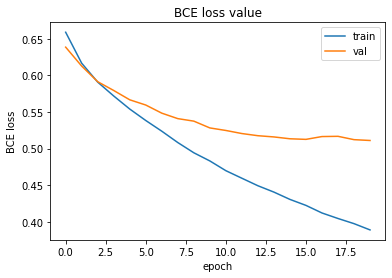

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

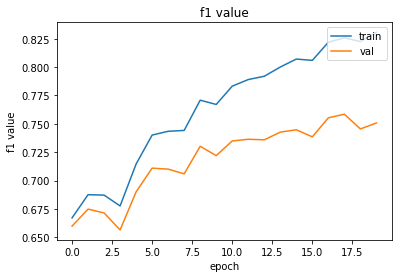

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(max(f1s_eval), np.array(f1s_eval).argmax())

tensor(0.7585, device='cuda:0') 17


In [ ]:
fp, fn, tp, tn, metr = predict(model, val_iterator)

45it [01:25,  1.91s/it]


In [ ]:
metr

{'precision': 0.7576965669988925,
 'recall': 0.7447318007662835,
 'f1-score': 0.7511582460531805}

In [ ]:
print(len(fp), len(fn), len(tp), len(tn))
# большой разницы между tp и tn нет, чуть больше fn, чем fp

5470 5863 17105 16929


In [ ]:
fp[:20]
#не всегда понимает иронию ('за минуту набежало четыре хороших человека которые тоже не видели этот великий сериал')
#слово "ужасный" не удается  негативным (поможет ли лемматизация?)
#вообще кажется, что он недооценивает негативность многих слов, с положительными все получше

['как же беркуты домой поедут USER еще три полицейских автобуса в киеве URL URL',
 'USER ну ладн не расстраивайся х что завтра делать планируешь',
 'rt USER USER снов с',
 'эх единственный номер который я помнил на придется забыть',
 'USER в другой раз будь осторожнее',
 'хочется стоять в толпе и кричать ура новому а вместо него по улице проходит дядя в под руки не болят от',
 'за минуту набежало четыре хороших человека которые тоже не видели этот великий сериал',
 'блять как же надоело жить от пятницы до пятницы от субботы до субботы заебало если честно URL',
 'USER а с кем с мамой а дальше чтоо на боковую так неинтересно',
 'USER ааа ну тогда молчу ты меня уделал',
 'театр слишком ужасен у всех актеров из роли в роль одни и те же интонации и манеры игры',
 'USER вернуться в феврале и стать еще лучше посмотрим я все еще не могу найти замену по',
 'USER от такой коленки гематома на пол будет',
 'бедные парни ваши 15 16 ти летние девочки сами не знают чего хотят от одного к другому наби

In [ ]:
fn[:20]
#какие-то проблемы с изначальной разметкой, почти все предложения я бы тоже отнесла к негативным  

['посмотрел ну и хрень но джоли нравится',
 'увидела маленьких подружек они за руку и болтали',
 'задал учит 3 стиха и я рассказала 1 стих 2 раза и вот тебе две 5 ки',
 'USER 1 тоже все время туда жму надо кнопку наклейку сделать',
 'USER а от меня нет mtvstars 3 second to mars',
 'USER зачем ты зубы',
 'USER пак я до тебя доберусь в след году а пока',
 'ну дальше по улице живет педофил которого вроде совсем не трогают ff follow',
 'USER ахаххахаха а я как то не очень люблю',
 'в горде пиздец как заметает я ебу нахуй жестко такая погода с братиком нам по душе',
 'rt USER а вы еще спрашиваете почему я ничего не пишу',
 'о этот огроменный ааааа 1 метр и 5 кг жесть больше половины меня',
 'rt USER есть какая почта в погонять',
 'rt USER вчера захватил настолько что я всю ночь его читал оторваться не мог теперь блин мне это вылазит боком и я ве',
 'афиша город пишет про моих одногруппников пишет что они тупые ебланы грубо говоря',
 'lt lt неужели окажется',
 'USER я же тебе написала что па

Улучшение в самом конце

## Модель с предобученными эмбеддингами

In [17]:
from gensim.models import FastText

ft = FastText(window=5, min_count=2, sentences=tweets_data['prep_text'])
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.normal(0,0.1,100)

In [ ]:
class FCNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.grams = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):

        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_grams = self.pooling(self.relu(self.grams(concat)))
        pooling3 = feature_map_grams.max(2)[0]
        logits = self.hidden(pooling3) 
        logits = self.out(logits)      
        return logits

In [ ]:
model = FCNN(len(word2id), 300)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)

print(max(f1s_eval), np.array(f1s_eval).argmax())


starting Epoch 0
Training...
Train loss: 0.6430420139256645
Train loss: 0.6023857368939165
Train loss: 0.581617993231003
Train loss: 0.5672408085075213
Train loss: 0.5551946459487936

Evaluating on train...
Val loss: 0.47664835610810447, Val f1: 0.7949100136756897
Val loss: 0.4700301682603532, Val f1: 0.7846121191978455
Val loss: 0.4686089908847442, Val f1: 0.78104168176651
Val loss: 0.4680680295975088, Val f1: 0.7786738872528076
Val loss: 0.4674306881838831, Val f1: 0.7778294086456299

Evaluating on test...
Val loss: 0.5624428875744343, Val f1: 0.8300518989562988
Val loss: 0.531057910007589, Val f1: 0.7821490168571472
Val loss: 0.5201458185911179, Val f1: 0.7709435820579529
Val loss: 0.5154277861118317, Val f1: 0.7647826671600342
Val loss: 0.5114186656745997, Val f1: 0.7606927156448364

starting Epoch 1
Training...
Train loss: 0.48044052720069885
Train loss: 0.4692219919052677
Train loss: 0.46328807135040945
Train loss: 0.45893549254472304
Train loss: 0.45630135892451495

Evaluating 

In [ ]:
fp, fn, tp, tn, metr = predict(model, val_iterator)
metr

45it [01:28,  1.97s/it]


{'precision': 0.7285928143712574,
 'recall': 0.8476140717520028,
 'f1-score': 0.7836097246820157}

## Датасет с символами и словами

In [12]:
class SymTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['prep_text'].values
        self.word2id = word2id
        self.sym2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        syms = list(self.dataset[index])
        words = word_tokenize(self.dataset[index])
        w_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        s_ids = torch.LongTensor([self.sym2id[sym] for sym in syms if sym in self.sym2id])
        y = [self.target[index]]
        return w_ids, s_ids, y

    def collate_fn(self, batch):
      wids, sids, y = list(zip(*batch))
      padded_wids = pad_sequence(wids, batch_first=True).to(self.device)
      padded_sids = pad_sequence(sids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_wids, padded_sids, y

In [13]:
train_dataset = SymTweetsDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = SymTweetsDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

## Модель с символами

In [27]:
class SCNN(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim):
        super().__init__()          
        self.wembedding = nn.Embedding(word_vocab_size, embedding_dim)
        self.wembedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.sembedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.emb2h = nn.Linear(100, 10)
        self.h2out = nn.Linear(190, 1)  
        self.relu = nn.ReLU()
        self.act2 = nn.Sigmoid() 
        
        
    def forward(self, words, syms):
        
        embedded = self.wembedding(words)
        mean_emb = torch.mean(embedded, dim=1)
        word_emb = self.emb2h(mean_emb)
        sym_emb = self.sembedding(syms).transpose(1,2)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(sym_emb)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(sym_emb)))
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)
        concat = torch.cat((concat, word_emb), 1)
        out = self.h2out(concat)
        proba = self.act2(out)
        
        return proba

In [37]:
def strain(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (ws, sms, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(ws, sms)
        loss = criterion(preds, ys)
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

def sevaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (wids, sids, ys) in enumerate(iterator):   
            preds = model(wids, sids)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)


def spredict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (words, syms, ys) in enumerate(iterator):   
            preds = model(words, syms)
            for pred, gold, word in zip(preds, ys, words):
              text = ' '.join([id2word[int(w)] for w in word if w !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    pr = len(tp) / (len(tp) + len(fp))
    rc = len(tp) / (len(tp) + len(fn))
    f1sc = 2*pr*rc / (pr + rc) 
    return fp, fn, tp, tn, {'precision': pr, 'recall': rc, 'f1-score': f1sc}

In [30]:
model = SCNN(len(word2id), len(symbol2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCELoss()  
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = strain(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = sevaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = sevaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7433311939239502
Train loss: 0.6594492896743442
Train loss: 0.6238732085778163
Train loss: 0.599554007001918
Train loss: 0.5790315561596004

Evaluating on train...
Val loss: 0.5048245340585709, Val f1: 0.8093041777610779
Val loss: 0.49336633302163385, Val f1: 0.8009685277938843
Val loss: 0.49068238500219125, Val f1: 0.7968689203262329
Val loss: 0.48987250533892956, Val f1: 0.794594943523407
Val loss: 0.4888004884980191, Val f1: 0.7933446168899536

Evaluating on test...
Val loss: 0.5699881017208099, Val f1: 0.8776243329048157
Val loss: 0.5395218870219063, Val f1: 0.8237985968589783
Val loss: 0.5313879595353053, Val f1: 0.8052682280540466
Val loss: 0.5286881770406451, Val f1: 0.7959586977958679
Val loss: 0.5242205519567836, Val f1: 0.7918329238891602

starting Epoch 1
Training...
Train loss: 0.4769461707157247
Train loss: 0.46487372897673346
Train loss: 0.4571418621792243
Train loss: 0.4525961189818897
Train loss: 0.4503116633357673

Evaluating

In [38]:
fp, fn, tp, tn, metr = spredict(model, val_iterator)
metr

{'precision': 0.7899903665305748,
 'recall': 0.7521072629602131,
 'f1-score': 0.7705834974046893}

In [39]:
print(len(fp), len(fn), len(tp), len(tn))

4578 5676 17221 17892


In [40]:
fp[:20]
# не всегда справляется с конфликтами пол. vs отриц. слов (убью vs добрые, адский vs радует)
# в некоторых предложениях нет никаких специфичных слов, которые могут помочь, и периодически не хватает контекста, чтобы самому понять окраску
# но есть ошибки и со словами "жалко, боюсь", то есть негативными

['USER стаса друг очень просит таню в принципе она мешать не будет но все равно',
 'прохождение the walking dead season 2 девочку жалко 4 URL',
 'rt USER я думаю у кое кого есть маленький секрет teamfollowback',
 'USER вася ааа как давно я его не видела',
 'USER USER какой то тогда если бы я это увидела спокойно не смогла бы уйти от туда',
 'они сейчас съедят все сушки как дальше принимать задачки',
 'USER USER USER а у нас в украине 2 уже забыл сколько недель восток а в крыму уже цветут деревья и все печально',
 'на работе мы внезапно решили заменить сервер на котором домена и прочие ad',
 'USER 8 6 в пяти минутах до школы и вечно опаздываю',
 'сегодня просто адский день хоть по конституции отчиталась одно радует',
 'лиз ты ушла из 62 da URL',
 'я бы предложила встретиться в любое удобное время для тебя но ты слишком занятой',
 'USER я вас сейчас убью но эти добрые люди барда и смауга',
 'USER пиздец как проверь веки руки',
 'USER я завтра просто я была сегодня занята с и',
 'USER я т

In [43]:
fn[:20]
# все еще сохраняется проблема с разметкой
# периодически влияют негативно окрашенные слова, которые в данном контексте не имеют негативных коннотаций (расплачусь, мат, жалоба)

['USER с мамой что то случилось обычно мы ее наряжаем прям под нг',
 'кристина меня и заботиться на фитнес приглашает вот так вот',
 'скоро по геометрии отличницей стану три 5 за последние контрольные',
 'USER я не удивлюсь если ты напишешь им жалобу что тебе смс не пришло',
 'USER вы как никогда владислав',
 'каждый день иди к цели будто и нет',
 'нет я решил сделать перерыв и не есть мясного вообще какое то время сосиски ветчина и т д на следующей неделе',
 'кто на пацаны из slipknot вродь называются ахуеть шутка',
 'думала что я дома одна но нет сестра проснулась',
 'бля надо искать платье на нг а мне так лееень',
 'USER один мой друг меня на один пункт в этом списке',
 'да 3 вечер сериал надо какой нибудь найти и смотреть',
 'USER там много плюсов 1 обновление т е когда загрузилась лента тебя не выкидывает в ее верх а остаешься где закончил читать',
 'пошла гулять с лучшей подругой все прохожие убегают в нарнию и думают что мы ахаха это про меня и',
 'ой ой ой ой ой вы серьезно gta

## Улучшение моделей: добавление пунктуации

In [45]:
tweets_data['prep_text'] = [text.lower() for text in tweets_data['text']]
train_data, val_data = train_test_split(tweets_data, test_size=0.2)
word_vocab = Counter()
for text in tweets_data['prep_text']:
    word_vocab.update(word_tokenize(text))
print('всего уникальных символов:', len(word_vocab))

filtered_word_vocab = set()

for word in word_vocab:
    if word_vocab[word] > 2:
        filtered_word_vocab.add(word)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_word_vocab))

word2id = {'PAD':0}

for word in filtered_word_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

sym_vocab = Counter()
for symbol in tweets_data['prep_text']:
    sym_vocab.update(list(symbol))
print('всего уникальных символов:', len(sym_vocab))

filtered_sym_vocab = set()

for symbol in sym_vocab:
    if sym_vocab[symbol] > 5:
        filtered_sym_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_sym_vocab))

symbol2id = {'PAD':0}

for symbol in filtered_sym_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

всего уникальных символов: 323972
уникальных символов, втретившихся больше 5 раз: 65696
всего уникальных символов: 385
уникальных символов, втретившихся больше 5 раз: 169


In [46]:
train_dataset = SymTweetsDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = SymTweetsDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [48]:
model = SCNN(len(word2id), len(symbol2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCELoss()  
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(1):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = strain(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = sevaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = sevaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.21863990953630386
Train loss: 0.11201766492340012
Train loss: 0.07545812473892091
Train loss: 0.05695359065137107
Train loss: 0.04567639956544501

Evaluating on train...
Val loss: 0.0010686312384410378, Val f1: 1.029268741607666
Val loss: 0.0008765000363211215, Val f1: 1.0144083499908447
Val loss: 0.0008614762751116919, Val f1: 1.0095295906066895
Val loss: 0.000859570981375203, Val f1: 1.0070953369140625
Val loss: 0.0009108060196807459, Val f1: 1.0056346654891968

Evaluating on test...
Val loss: 0.0010821388823387679, Val f1: 1.1248828172683716
Val loss: 0.0009137498461367452, Val f1: 1.0587109327316284
Val loss: 0.0008506488677364989, Val f1: 1.0383878946304321
Val loss: 0.000836358210238229, Val f1: 1.028489112854004
Val loss: 0.0008160135079048235, Val f1: 1.0226397514343262


In [49]:
fp, fn, tp, tn, metr = spredict(model, val_iterator)
metr

{'precision': 0.9998262606958259,
 'recall': 1.0,
 'f1-score': 0.9999131228009209}

In [50]:
print(len(fp), len(fn), len(tp), len(tn))

4 0 23019 22344


In [52]:
fp
# Непонятные твиты, которые еще и непонятно почему негативные
# Да здравствуют смайлики!

['то чувство , когда твой лайк 6666 о_о http :',
 "заза , сайхан , `` ажил '' ээ , хэх… : -/ # баас # : p",
 'rt @ palmjuliefrost : 4 000 * -- -- -* посвящение : @ @ @ @ @ imapotato_ouo я вас люблю',
 'мама : - , ты не проспал я : - я еще не ложился : |']

In [58]:
#Улучшение 1 модели
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(1):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.18916034758748376
Train loss: 0.10254128946774248
Train loss: 0.07170929650041777
Train loss: 0.05557144834432188
Train loss: 0.045980331604368985

Evaluating on train...
Val loss: 0.005724139415713794, Val f1: 1.027681589126587
Val loss: 0.005513945418963398, Val f1: 1.0127688646316528
Val loss: 0.005470135612995364, Val f1: 1.007906436920166
Val loss: 0.005322808749042451, Val f1: 1.0055369138717651
Val loss: 0.0052769365044706765, Val f1: 1.0040948390960693

Evaluating on test...
Val loss: 0.00860236119478941, Val f1: 1.1219595670700073
Val loss: 0.006826780640574939, Val f1: 1.056486964225769
Val loss: 0.006650491017633333, Val f1: 1.0362749099731445
Val loss: 0.006798500388062426, Val f1: 1.0263086557388306
Val loss: 0.006975630663377656, Val f1: 1.0204250812530518


In [66]:
fp, fn, tp, tn, metr = predict(model, val_iterator)
print(metr)
print(len(fp), len(fn), len(tp), len(tn))

{'precision': 0.9986073635651492, 'recall': 0.9968287067205353, 'f1-score': 0.997717242428854}
32 73 22946 22316


In [63]:
fp
#опять разметка вызывает вопросы
# иногда обманки-позитивные слова (1 пр.)

['@ veeetch всё отлично , если не считать того что я заболела и у меня голос пропадает ( ихихих слышал бы ты меня : d',
 'rt @ tao_oppa : я нашел свою папку с оо http :',
 'внезапно вспомнила , что мне сегодня снился о_о там и другие , но его прям хорошо помню :3',
 'rt @ : @ seo_optimizator вот где можно заработать в интернете https :',
 '@ , охренеть ! у меня вообще слов нет ! o_o а мы тут радуемся 6 : -|',
 '@ samo_obayaniye это ты так думаешь , а слог думает иначе',
 '@ mihaylenko_o знакомо многим , у кого есть младшие твари тот нам надо .',
 '# rt но мы остались в больнице с пятницы по воскресенье o_o # ff # follow',
 'разговор на работе : с : я за праздники набрала 6 кг ! л : а я 3,5 я : а я 1. c , л : o_o fuck yeah !',
 '@ можно ставить галочку в : /',
 'ничего не купила себе из одежды ( вместо этого везу ковер и кучу себе в общагу : d',
 '( лазерный hp цвет : black ресурс : стр',
 'rt @ radio_of_moon : модные достаточно оригинальная и стильная обувь http :',
 '@ blo_odred моде 

In [65]:
fn[:20]
# возможно, считает ^_^ и большое кол-во ! негативным
# хотя попалось достаточно много примеров со словами с очень ярко-выраженным позитивным окрасом

['rt @ : @ love_niall99 не боись , всегда и всюду с тобой : *удачи , лю типя ! ! !',
 '@ : . сегодня фильм в дк есть ? да ?',
 'rt @ : @ с рождения тебя ! ! успехов во всех начинаниях , здоровья , оставайся http : //…',
 'у любимой моей глазки http :',
 'rt @ : @ im_your_maniac : dddd',
 'rt @ : наверное , стоит дать им минутку побыть вдвоём , перед операцией . *^_^* # teamfollowback',
 'украсили комнату и нарядили ёлочку =^_^= http :',
 '@ lirvana_ @ fucking_chaw @ killjoy_greenka @ 666_idiot @ deatbeatholiday @ fuck_time01 ну гоу гоу : вы там охранников не , а то',
 'rt @ : @ ты всегда лапочка',
 '@ адрес адрес адрес ! ! ты сказал мне адрес ! ! ! а теперь будь осторожнее ! ! :',
 'думаю стоит поздравить одну из самых @ с днем рождения:3 желаю не заболеть в и пошире глотку',
 'круто , зато на химию не ходила : не нравится мне этот предмет',
 '@ @ khatsevich_ann ^_^ надежда , рб , г. минск , ул . , , кв . , индекс .',
 ') @ область http :',
 '@ я сказала свои нет : половина левые вообщ